In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import numpy as np
import scipy
from scipy.optimize import curve_fit

#### load data

In [3]:
input_csv = "vidro-1kHz-80mBias3.csv"

df = pd.read_csv(input_csv, comment='#', names=['x', 'y', 'p', 't'])
df.head()

,x,y,p,t
0,727,291,0,7184
1,730,291,0,7184
2,735,291,0,7184
3,739,291,0,7184
4,742,291,0,7184


### Filter (small region just to calculate phase per pixel) and see the ROI


Number of data points: 1312
             x    y  p        t
145359255  720  240  1  1100800
145359256  721  240  1  1100800
145359257  722  240  1  1100800
145359258  724  240  1  1100800
145359259  725  240  1  1100800
...        ...  ... ..      ...
145367113  722  384  1  1100850
145367116  720  387  0  1100850
145367117  721  387  0  1100850
145367118  723  387  0  1100850
145367119  725  387  0  1100850

[1312 rows x 4 columns]
Time range: 1100800 to 1100850
Filtered data:
     x    y  p        t
0  720  240  1  1100800
1  721  240  1  1100800
2  722  240  1  1100800
3  724  240  1  1100800
4  725  240  1  1100800
Number of events: 1312
Density array shape: (205588,)
Density indices shape: (1312,)
Max density index: 152439
Min density index: 13503
Densities size: 205588
Density indices (first 10): [50264 50264 50264 50264 50264 50676 50676 50676 50676 50676]


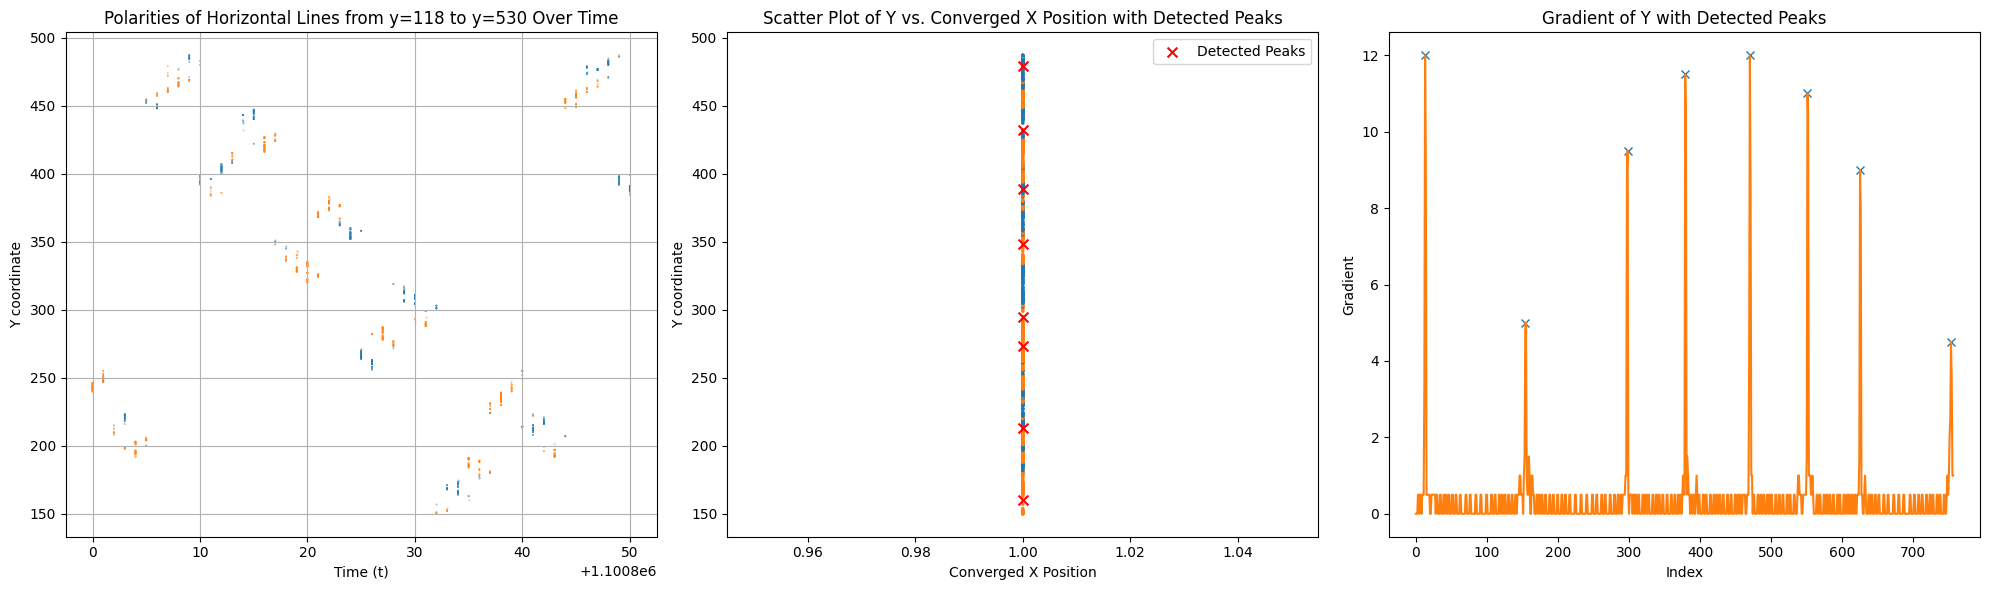

[160 213 273 295 348 389 432 479]


In [4]:
from polarityarea2 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Define the parameters
tmin = 1100800
tmax = 1100850
ymin = 118
ymax = 530
xmin = 720
xmax = 725
polarity = None

# Filter the DataFrame for the specified horizontal line of pixels
line_df = df[(df['x'] >= xmin) & (df['x'] <= xmax) & (df['y'] >= ymin) & (df['y'] <= ymax)]

# Apply time filtering if specified
if tmin is not None:
    line_df = line_df[line_df['t'] >= tmin]
if tmax is not None:
    line_df = line_df[line_df['t'] <= tmax]

# Check if the filtered DataFrame is empty
if line_df.empty:
    print("No data points found for the given filters.")
else:
    print(f"Number of data points: {len(line_df)}")
    print(line_df)
    print(f"Time range: {line_df['t'].min()} to {line_df['t'].max()}")
    line_df.head()

# Sort the data based on y
x = line_df['x'].to_numpy()
y = line_df['y'].to_numpy()
t = line_df['t'].to_numpy()
p = line_df['p'].to_numpy()

idx = np.argsort(y)
x = x[idx]
y = y[idx]
t = t[idx]
p = p[idx]

# Separate the data based on polarity
yp = y[p == 1]
yn = y[p == 0]

# Calculate the gradient of yp
gradyp = np.gradient(yp)

# Find peaks in the gradient of the y data for polarity = 1
peaksidx, _ = find_peaks(gradyp, distance=10, prominence=2)

# Create the ysplit and phisplit arrays
ysplit = yp[peaksidx]
phisplit = np.arange(0, 2 * np.pi * len(ysplit), 2 * np.pi)

# Create a subplot grid with 1 row and 3 columns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# First plot: Using plot_lines_polarity_over_time
plot_lines_polarity_over_time(input_csv, xmin, xmax, ymin, ymax, tmin, tmax, polarity, ax=ax1)

# Second plot: Scatter plot of y vs. position (converged x)
colors = ["C0", "C1"]
colors_vec = [colors[p] for p in line_df['p']]

# Set all x positions to the same value (e.g., 1) to align them vertically
converged_x = np.ones(len(t))
ax2.scatter(converged_x, y, s=2, c=colors_vec)

# Overlay the detected peaks on the scatter plot
ax2.scatter(converged_x[peaksidx], yp[peaksidx], s=50, c="red", marker="x", label="Detected Peaks")

# Configure labels and title for the second plot
ax2.set_xlabel('Converged X Position')
ax2.set_ylabel('Y coordinate')
ax2.set_title('Scatter Plot of Y vs. Converged X Position with Detected Peaks')
ax2.legend()

# Third plot: Gradient of y with peaks
ax3.plot(peaksidx, abs(gradyp[peaksidx]), "x")
ax3.plot(gradyp)
ax3.set_title('Gradient of Y with Detected Peaks')
ax3.set_xlabel('Index')
ax3.set_ylabel('Gradient')

plt.tight_layout()
plt.show()

print(ysplit)


In [5]:
phisplit

array([ 0.        ,  6.28318531, 12.56637061, 18.84955592, 25.13274123,
       31.41592654, 37.69911184, 43.98229715])

[0.         0.11855067 0.23710133 0.355652   0.47420266 0.59275333
 0.711304   0.82985466 0.94840533 1.066956   1.18550666 1.30405733
 1.42260799 1.54115866 1.65970933 1.77825999 1.89681066 2.01536132
 2.13391199 2.25246266 2.37101332 2.48956399 2.60811466 2.72666532
 2.84521599 2.96376665 3.08231732 3.20086799 3.31941865 3.43796932
 3.55651999 3.67507065 3.79362132 3.91217198 4.03072265 4.14927332
 4.26782398 4.38637465 4.50492531 4.62347598 4.74202665 4.86057731
 4.97912798 5.09767865 5.21622931 5.33477998 5.45333064 5.57188131
 5.69043198 5.80898264 5.92753331 6.04608397 6.16463464 0.
 0.10471976 0.20943951 0.31415927 0.41887902 0.52359878 0.62831853
 0.73303829 0.83775804 0.9424778  1.04719755 1.15191731 1.25663706
 1.36135682 1.46607657 1.57079633 1.67551608 1.78023584 1.88495559
 1.98967535 2.0943951  2.19911486 2.30383461 2.40855437 2.51327412
 2.61799388 2.72271363 2.82743339 2.93215314 3.0368729  3.14159265
 3.24631241 3.35103216 3.45575192 3.56047167 3.66519143 3.76991118
 3.

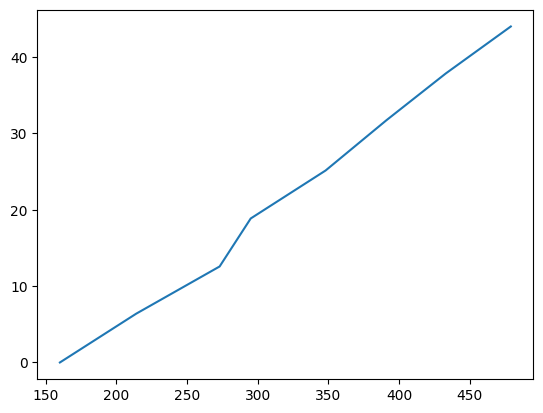

In [6]:
yroi = np.arange(ysplit[0], ysplit[-1] + 1)
phiroi = np.interp(yroi, ysplit, phisplit)
plt.plot(yroi, phiroi)
phiroi = np.mod(phiroi, 2 * np.pi) #between 0,2pi
print(phiroi)

### filter data (main data- bigger time period)

In [7]:
%matplotlib inline
# Define the parameters
tmin = 1100000
tmax = 2000000
ymin = yroi[0]
ymax = yroi[-1]


# Filter the DataFrame for the specified horizontal line of pixels
line_df = df[(df['x'] >= xmin) & (df['x'] <= xmax) & (df['y'] >= ymin) & (df['y'] <= ymax)]

# Apply time filtering if specified
if tmin is not None:
    line_df = line_df[line_df['t'] >= tmin]
if tmax is not None:
    line_df = line_df[line_df['t'] <= tmax]

# Check if the filtered DataFrame is empty
if line_df.empty:
    print("No data points found for the given filters.")
else:
    print(f"Number of data points: {len(line_df)}")
    print(line_df)
    print(f"Time range: {line_df['t'].min()} to {line_df['t'].max()}")
    line_df.head()


Number of data points: 19090596
             x    y  p        t
145251771  720  381  1  1100000
145251772  721  381  1  1100000
145251773  722  381  1  1100000
145251774  723  381  1  1100000
145251775  724  381  1  1100000
...        ...  ... ..      ...
264893447  723  232  1  2000000
264893448  724  232  1  2000000
264893449  725  232  1  2000000
264893478  722  242  0  2000000
264893500  721  241  0  2000000

[19090596 rows x 4 columns]
Time range: 1100000 to 2000000


### phase per pixel method application

yp: [221 219 219 ...  76  76  75]
phiroi: 5.334779977793989
phase: [5.05719793 4.75070109 4.75070109 ... 2.40855437 2.40855437 2.30383461]
12123428
12123428


(0.0, 2000.0)

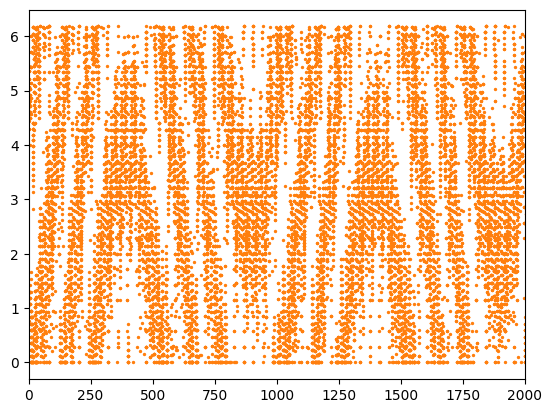

In [8]:

colors = ["C0", "C1"]

colors_vec = [colors[p] for p in line_df['p']]
x = line_df['x']
p = line_df['p']
t = line_df['t']
y = line_df['y']

x = np.array(x)
y = np.array(y)
p = np.array(p)
t = np.array(t)

idx = np.argsort(t)

x = x[idx]
y = y[idx]
t = t[idx]
p = p[idx]

t = t-t[0]

yp = y[p==1]
tp = t[p==1]
yn = y[p==0]

tp = tp-tp[0]

yp = yp-ymin

phase = np.array([phiroi[yi] for yi in yp])

print("yp:", yp)
print("phiroi:", phiroi[180])
print("phase:", phase)
##yp = np.mod(yp, pixels_per_period)
#yp = np.mod(yp, 84)

tp_uniques = np.unique(tp)

##phase = yp*phaseperpixel
print(len(tp))
print(len(phase))
plt.scatter(tp, phase, s=2, c="C1")
plt.xlim(0,2000)

### Calculation of phase (centroids)

In [9]:
tp_uniques = np.unique(tp)
centroid_y = []
tval_vec = []

for i,tval in enumerate(tp_uniques):
    yval = phase[tp==tval]
    ycomplex = np.cos(yval)+1j*np.sin(yval)

    ymean = np.angle(np.mean(ycomplex))

    
    #print(i, ymean)
    centroid_y.append(ymean)
    tval_vec.append(tval)

    if i > 5500:
        break

centroid_y = np.array(centroid_y)
tval_vec = np.array(tval_vec)


In [10]:
centroid_y,tval_vec

(array([-1.35102814,  0.76624211, -0.83775804, ...,  2.84554782,
        -2.75766992, -1.65970933]),
 array([   0,    2,    3, ..., 6504, 6505, 6507], dtype=int64))

### phases of events over time

(0.0, 2000.0)

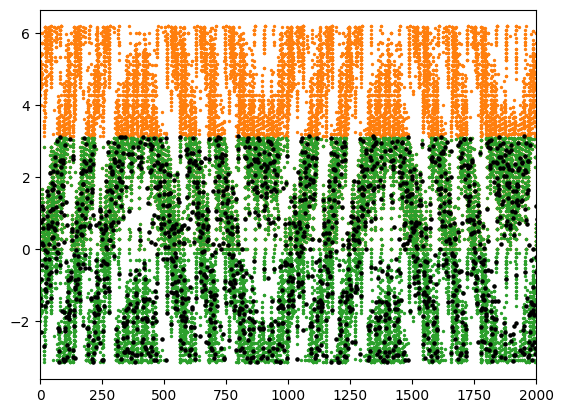

In [11]:
plt.scatter(tp, phase, s=2, c="C1")
plt.scatter(tp, np.mod(phase+np.pi, 2*np.pi)-np.pi, s=2, c="C2")
plt.scatter(tval_vec, centroid_y, s=5, c="k")
plt.xlim(0,2000)

### plot of the real and imaginary parts of complex numbers representing phase centroids

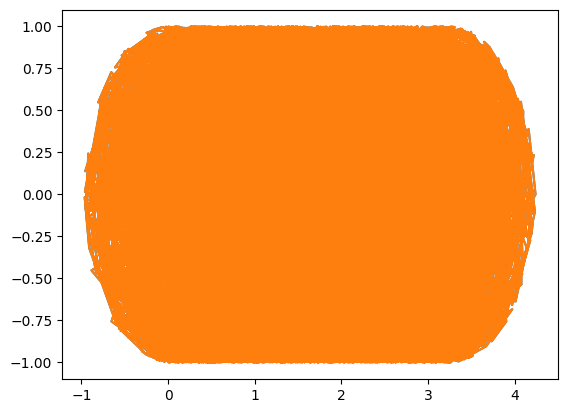

In [12]:
phase_complex = np.cos(centroid_y)+1j*np.sin(centroid_y)

#phase_complex = phase_complex[:100]

plt.plot(phase_complex.real+tval_vec/2000, phase_complex.imag, '-')
plt.plot(phase_complex.real+tval_vec/2000, phase_complex.imag, '-')


### Kalman filter to smooth the phase data derived from the centroid phases

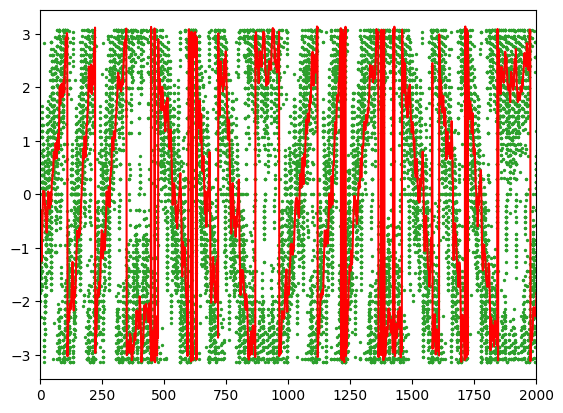

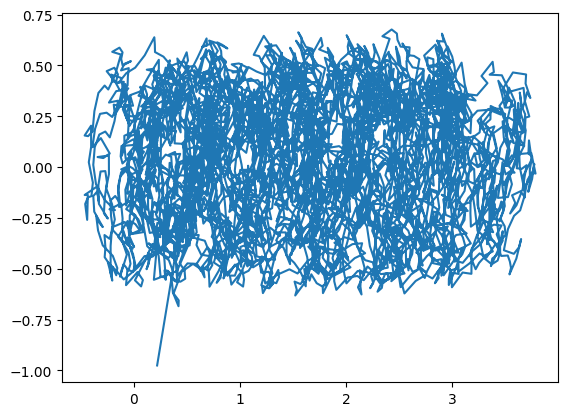

In [13]:
from kalman import KalmanTracking


Track = KalmanTracking()
Track.cov = 0.5 #Sets the initial covariance, representing the uncertainty in the initial state estimate.
Track.error_proc = 0.0001 #Sets the estimated process error, representing how much you expect the process to vary between steps.
Track.error_measurement = 0.01+0.01j #Sets the estimated measurement error, which includes both real and imaginary components.

complex_kalman = np.array([Track(c) for c in phase_complex])
phase_kalman = np.angle(complex_kalman)
#plt.plot(phase_complex.real+tval_vec/10000, phase_complex.imag, '.')
#plt.plot(phase_kalman.real+tval_vec/10000, phase_kalman.imag, '.')


plt.figure()
plt.scatter(tp, np.mod(phase+np.pi, 2*np.pi)-np.pi, s=2, c="C2")
#plt.scatter(tval_vec, centroid_y, s=5, c="k")
plt.plot(tval_vec, phase_kalman, c="r")
plt.xlim(0,2000)

plt.figure()
plt.plot(complex_kalman.real+tval_vec/2000, complex_kalman.imag, '-')


12.416027322632594

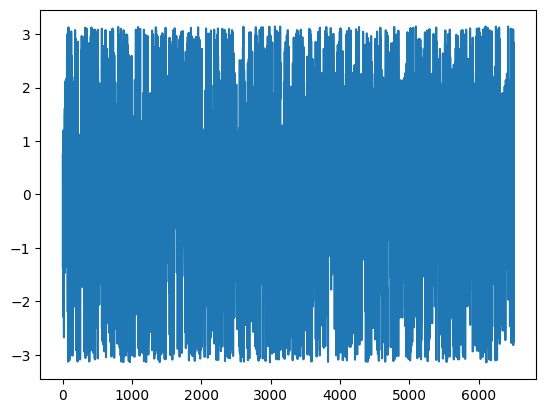

In [14]:
plt.plot(tval_vec, centroid_y)




np.ptp(np.diff(centroid_y)).max()


### Phase Unwrapping and Continuous Phase Analysis


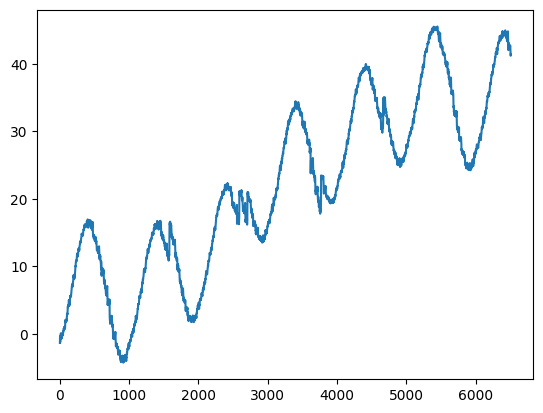

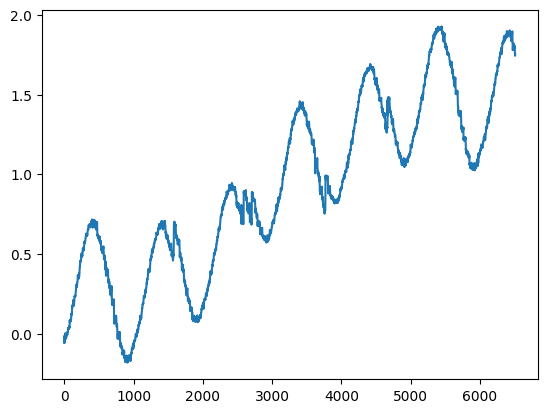

In [15]:
wavelength = 532e-9
centroid_y = np.unwrap(centroid_y)
centroid_y = np.unwrap(phase_kalman)

diff_phase = centroid_y - np.append([centroid_y[0]], np.diff(centroid_y))
plt.plot(tval_vec, centroid_y)
#plt.plot(tval_vec, diff_phase)
z = centroid_y/(2*np.pi)*wavelength/2

plt.figure()
plt.plot(tval_vec, z/1e-6)


### Displacement calc (nano)

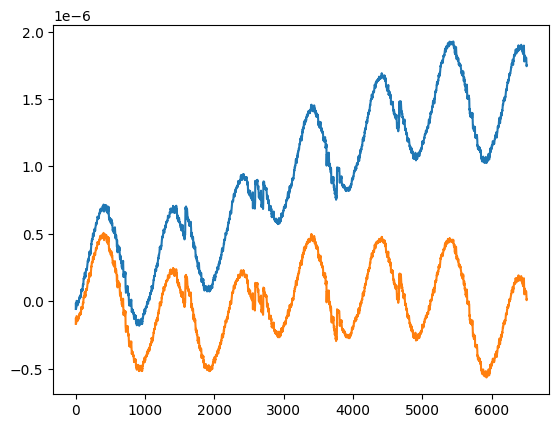

In [16]:
t_step = 1

t_interp = np.arange(tval_vec.min(), tval_vec.max(), t_step)
z_interp = np.interp(t_interp, tval_vec, z)

plt.plot(t_interp, z_interp)

z_detrend = scipy.signal.detrend(z_interp)
plt.plot(t_interp, z_detrend)


### FFT for finding main frequency of the signal

(0.0, 2000.0)

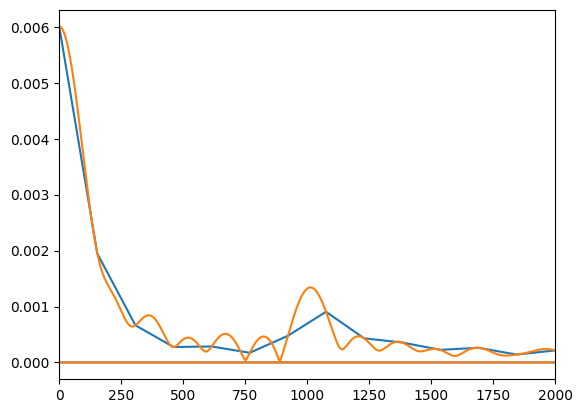

In [17]:
a = np.pad(z_interp, len(z_interp)*2)
a = np.pad(z_interp, 2**20-1)


ft = np.fft.fft(z_interp)
freqs = np.fft.fftfreq(len(ft), d=t_step*1e-6)

plt.plot(freqs, np.abs(ft))

ft = np.fft.fft(a)
freqs = np.fft.fftfreq(len(ft), d=t_step*1e-6)

plt.plot(freqs, np.abs(ft))

plt.xlim(0, 2000)

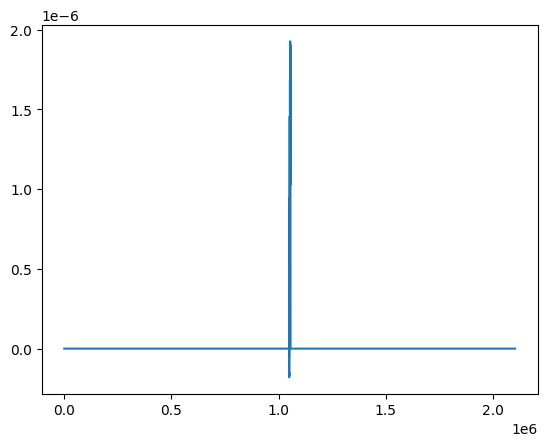

In [18]:
#a = np.pad(z_interp, len(z_interp)*2)

plt.plot(a)